<h4 align="right">6th of April 2020</h4>
<h1 align="center">Neural Networks and Deep Learning (CIE 555)</h1>
<h2 align="center">Lab 9: Autoencoders</h2> <br>

# A Simple Autoencoder

We'll start off by building a simple autoencoder to compress the MNIST dataset. With autoencoders, we pass input data through an encoder that makes a compressed representation of the input. Then, this representation is passed through a decoder to reconstruct the input data. Generally the encoder and decoder will be built with neural networks, then trained on example data.

![alt text](https://miro.medium.com/max/703/1*z5baTwQbFNC-YBPZLZubzA.png)

In this notebook, we'll be build a simple network architecture for the encoder and decoder. Let's get started by importing our libraries and getting the dataset.

In [0]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [0]:
from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, -1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, -1))
test_images = test_images.astype('float32') / 255


Below I'm plotting an example image from the MNIST dataset. These are 28x28 grayscale images of handwritten digits.

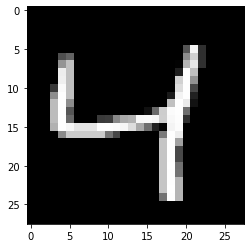

In [24]:
img = train_images[2]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

We'll train an autoencoder with these images by flattening them into 784 length vectors. The images from this dataset are already normalized such that the values are between 0 and 1. Let's start by building basically the simplest autoencoder with a **single ReLU hidden layer**. This layer will be used as the compressed representation. Then, the encoder is the input layer and the hidden layer. The decoder is the hidden layer and the output layer. Since the images are normalized between 0 and 1, we need to use a **sigmoid activation on the output layer** to get values matching the input.

![alt text](https://media.springernature.com/original/springer-static/image/chp%3A10.1007%2F978-3-030-31756-0_4/MediaObjects/480626_1_En_4_Fig4_HTML.png)



In [0]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model

encoding_dim = 32
image_size = train_images.shape[1]

# This returns a tensor
inputs = layers.Input(shape=(784,), name = 'input_image')

# a layer instance is callable on a tensor, and returns a tensor
encoded = layers.Dense(encoding_dim, activation='relu', name = 'encoded')(inputs) ## The output of this layer represents the encoding vector
output_image = layers.Dense(784, activation='sigmoid', name = 'reconstructed')(encoded)

model = Model(inputs=inputs, outputs=output_image)


In [26]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
encoded (Dense)              (None, 32)                25120     
_________________________________________________________________
reconstructed (Dense)        (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


## Training

In [27]:
model.compile(optimizer='adam',
              loss='mean_squared_error')
model.fit(train_images, train_images, epochs=10, batch_size=64)

Epoch 1/10
938/938 [==============================] - 2s 2ms/step - loss: 0.0421
Epoch 2/10
938/938 [==============================] - 2s 2ms/step - loss: 0.0183
Epoch 3/10
938/938 [==============================] - 2s 2ms/step - loss: 0.0134
Epoch 4/10
938/938 [==============================] - 2s 2ms/step - loss: 0.0116
Epoch 5/10
938/938 [==============================] - 2s 2ms/step - loss: 0.0109
Epoch 6/10
938/938 [==============================] - 2s 2ms/step - loss: 0.0107
Epoch 7/10
938/938 [==============================] - 2s 2ms/step - loss: 0.0105
Epoch 8/10
938/938 [==============================] - 2s 2ms/step - loss: 0.0104
Epoch 9/10
938/938 [==============================] - 2s 2ms/step - loss: 0.0103
Epoch 10/10
938/938 [==============================] - 2s 2ms/step - loss: 0.0103


## Checking out the results

Below we plot some of the test images along with their reconstructions. For the most part these look pretty good except for some blurriness in some parts.

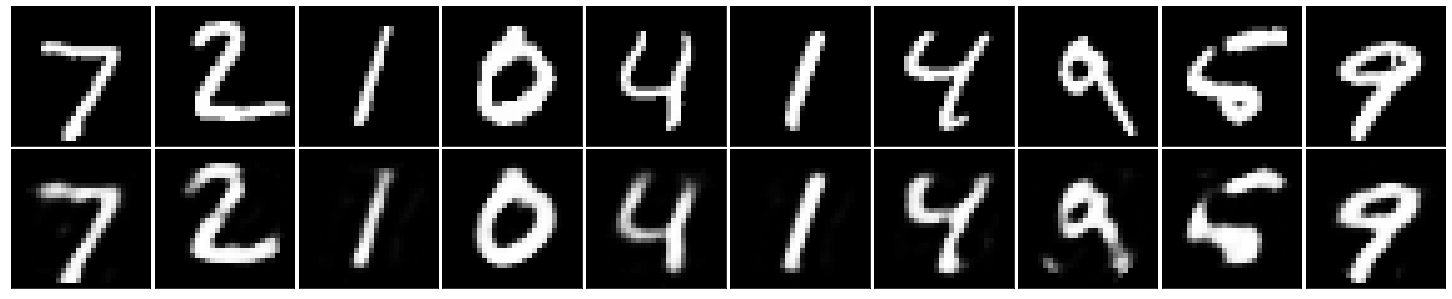

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = test_images[:10]
#reconstructed, compressed = sess.run([decoded, encoded], feed_dict={inputs_: in_imgs})
reconstructed = model.predict(in_imgs)
for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)

## Up Next

We're dealing with images here, so we can (usually) get better performance using convolution layers. 

In practice, autoencoders aren't actually better at compression compared to typical methods like JPEGs and MP3s. But, they are being used for noise reduction, which we'll build using convolution layers.

# Denoising Autoencoder



Autoencoders can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1. We'll use noisy images as input and the original, clean images as targets. Here's an example of some noisy images generated and the denoised images.

![alt text](https://static.packt-cdn.com/products/9781788399906/graphics/f9b44226-662e-43a1-aaa8-f9f952d8ce60.png)



In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import keras
from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

np.random.seed(1337)

In [0]:
# MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])

## Normalize the data
x_train = x_train.astype('float32') / 255      
x_test = x_test.astype('float32') / 255

In [39]:
x_train.shape

(60000, 28, 28, 1)

In [0]:
# Generate corrupted MNIST images by adding noise with normal dist
# centered at 0.5 and std=0.5
noise = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
x_train_noisy = x_train + noise
noise = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
x_test_noisy = x_test + noise

# Clip the images to be between 0 and 1
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


We build our encoder using a stack of convolutional layers of stride=2 that successively reduce the image size by 2. We then flatten the network and construct our latent vector (code vector). The latent-space representation is the compressed form of our data.

From there, we have built the encoder portion of our autoencoder.

Next, we’ll use our latent-space representation to reconstruct the original input image.

In [41]:
# Network parameters
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
latent_dim = 16  ## the coded vector dimension

# Encoder/Decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

# Build the Autoencoder Model
# First build the Encoder Model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# Stack of Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use MaxPooling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

# Shape info needed to build Decoder Model
shape = K.int_shape(x)

# Generate the latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# Instantiate Encoder Model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________


Here, we are taking the latent input and use a fully-connected layer to reshape it into a 3D volume (i.e., the image data).

We loop over our filters again, but in reverse order, applying CONV_TRANSPOSE layers where the CONV_TRANSPOSE layer’s purpose is to increase the volume size. Transposed convolution layers are used to increase the width and height of the layers. They work almost exactly the same as convolutional layers, but in reverse. A stride in the input layer results in a larger stride in the transposed convolution layer. For example, if you have a 3x3 kernel, a 3x3 feature map in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 feature map in a transposed convolution layer. Checkout Keras transposed convolution layer module [`Conv2DTranspose`](https://keras.io/layers/convolutional/). 


## **Exercise**

In [42]:
# Build the Decoder Model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# Stack of Transposed Conv2D blocks

############ To Be Done #####################################

## Add Conv2DTranspose layers with upsampling factor of 2 ## Use same kernel size and activation as in encoder layers.  
x = Conv2DTranspose(filters=64,kernel_size=kernel_size,activation='relu', strides=2, padding='same')(x)
x = Conv2DTranspose(filters=32,kernel_size=kernel_size,activation='relu', strides=2, padding='same')(x)
        
## Add the final Conv2DTranspose layer with filters=1 to get the final output image with 1 channel
x = Conv2DTranspose(filters=1,kernel_size=kernel_size,strides=1, padding='same')(x)
     
  ##############################################################

outputs = Activation('sigmoid', name='decoder_output')(x)

# Instantiate Decoder Model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 16)]              0         
_________________________________________________________________
dense_5 (Dense)              (None, 3136)              53312     
_________________________________________________________________
reshape_5 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_15 (Conv2DT (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_16 (Conv2DT (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_17 (Conv2DT (None, 28, 28, 1)         289       
_________________________________________________________________
decoder_output (Activation)  (None, 28, 28, 1)         0   

Finally, we construct the autoencoder (encoder followed by decoder). 

In [43]:
# Autoencoder = Encoder + Decoder
# Instantiate Autoencoder Model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Model)              (None, 16)                69008     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         108993    
Total params: 178,001
Trainable params: 178,001
Non-trainable params: 0
_________________________________________________________________


## Training our Autoencoder

In [44]:
autoencoder.compile(loss='mse', optimizer='adam')

# Train the autoencoder
autoencoder.fit(x_train_noisy,
                x_train,
                validation_split = 0.2,
                #validation_data=(x_test_noisy, x_test),
                epochs=30,
                batch_size=batch_size)

Epoch 1/30
375/375 [==============================] - 71s 189ms/step - loss: 0.0701 - val_loss: 0.0454
Epoch 2/30
375/375 [==============================] - 71s 188ms/step - loss: 0.0310 - val_loss: 0.0247
Epoch 3/30
375/375 [==============================] - 74s 196ms/step - loss: 0.0226 - val_loss: 0.0212
Epoch 4/30
375/375 [==============================] - 71s 189ms/step - loss: 0.0203 - val_loss: 0.0197
Epoch 5/30
375/375 [==============================] - 71s 190ms/step - loss: 0.0190 - val_loss: 0.0188
Epoch 6/30
375/375 [==============================] - 71s 190ms/step - loss: 0.0182 - val_loss: 0.0184
Epoch 7/30
375/375 [==============================] - 71s 190ms/step - loss: 0.0177 - val_loss: 0.0183
Epoch 8/30
375/375 [==============================] - 71s 190ms/step - loss: 0.0172 - val_loss: 0.0177
Epoch 9/30
375/375 [==============================] - 71s 189ms/step - loss: 0.0169 - val_loss: 0.0176
Epoch 10/30
375/375 [==============================] - 71s 189ms/step - l

## Checking out the performance

Here we are adding noise to the test images and passing them through the autoencoder. It does a suprising great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

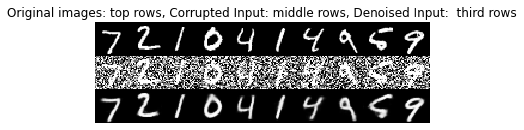

In [45]:
# Predict the Autoencoder output from corrupted test images
x_decoded = autoencoder.predict(x_test_noisy)

# Display the 1st 10 corrupted and denoised images
rows, cols = 1, 10
num = rows * cols
imgs = np.concatenate([x_test[:num], x_test_noisy[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)
plt.figure()
plt.axis('off')
plt.title('Original images: top rows, '
          'Corrupted Input: middle rows, '
          'Denoised Input:  third rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
Image.fromarray(imgs).save('corrupted_and_denoised.png')
plt.show()